In [ ]:
print("hello world")

In [7]:
import os, getpass

def _set_env(var: str):
    if not os.environ.get(var):
        os.environ[var] = getpass.getpass(f"{var}: ")

_set_env("LANGSMITH_API_KEY")

In [1]:
from utilities.llm_manager import LLMManager
from utilities.config_manager import load_config
from utilities.file_management import read_files
from utilities.generate_tree_graph import generate_tree_human_readable

from graphs.init_context_graph import build_graph as build_init_graph

from IPython.display import Image, display

from langgraph.checkpoint.memory import MemorySaver

import os, getpass

def init_state():
    project_root = get_config()["project-root"]
    summary_path = Path(get_config()["project-root"]) / "summary.md"
    if summary_path.exists():
        existing_summary = read_files("summary.md", project_root)
    else:
        existing_summary = ""
    project_structure = generate_tree_human_readable(get_config()["project-root"])
    return {"messages": [], "files_to_read": [], "file_contents": [], "cli_input": "", "summary": existing_summary, "project_structure": project_structure, "recursion_count":0}


os.environ["LANGSMITH_TRACING"] = "true"
os.environ["LANGSMITH_PROJECT"] = "init-context-graph"
os.environ["LANGSMITH_API_KEY"] = "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"

✅ Loaded config from: /Users/justin.mascotto/Projects/ASTparser/code-gen/config.yaml


In [ ]:
graph_builder = build_init_graph()

memory = MemorySaver()
graph = graph_builder.compile(checkpointer=MemorySaver())

#display(Image(graph.get_graph(xray=True).draw_mermaid_png()))

/Users/justin.mascotto/Projects/ASTparser/code-gen/claude_rag.py:30: LangChainDeprecationWarning: The class `HuggingFaceEmbeddings` was deprecated in LangChain 0.2.2 and will be removed in 1.0. An updated version of the class exists in the :class:`~langchain-huggingface package and should be used instead. To use it run `pip install -U :class:`~langchain-huggingface` and import as `from :class:`~langchain_huggingface import HuggingFaceEmbeddings``.
  embedding_model = HuggingFaceEmbeddings(model_name=config["embedding"]["model"])
/Users/justin.mascotto/Projects/ASTparser/code-gen/code-gen/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [9]:
thread = {"configurable": {"thread_id": "1"}}

initState = {"messages":[], "files_to_read":[], "file_contents":[]}

for event in graph.stream(initState, thread, stream_mode="values"):
    if len(event['messages']) > 0:
        event['messages'][-1].pretty_print()

================================ Human Message =================================


You are a senior software engineer and your task today is to understand 
and summarize the architecture of a project. You will be given a project
directory structure and you will be able to retrieve files of interest 
you may want to inspect in order to understand things like the framework
being used, persistence, messaging systems, service responsibilities.
Being fiscally conservative engineer that wants results quickly, you should
not analyze all files but only ones that are crucial to your understanding. 

Below is the project structure
├── .gitignore
├── .gitlab-ci.yml
├── Labfile.main.kts
├── audit-log-api
│   ├── build.gradle.kts
│   └── src
│       ├── integration-test
│       │   └── kotlin
│       │       └── com
│       │           └── w2g
│       │               └── auditlog
│       │                   └── api
│       │                       └── integration
│       │                           

In [ ]:
thread = {"configurable":{"thread_id":1}}
state = graph.get_state(thread)
print(state)

In [2]:
import json
from collections import deque

from langgraph.prebuilt import ToolNode
from langgraph.graph import MessagesState
from langgraph.graph import StateGraph, END, START
from langgraph.types import Command
from langchain_core.messages import HumanMessage, SystemMessage
from graphs.llm_provider import get_llm_manager
from graphs.config_provider import get_config
from graphs.tools.read_file_tool import read_file
from graphs.tools.vector_store_tool import retrieve_relevant_code
from utilities.retrieval_manager import RetrievalManager

planner_node_system_prompt="""
You are a senior software engineer. It is your job to interpret any question being asked and decompose 
it into smaller more focused tasks. You should only respond in json format. For instance, if you were 
asked "Create a persistence layer for model X with basic CRUD operations", you might respond with 
'{{"tasks":["Create DAO class for model X with basic CRUD operations","Create unit test for the DAO class"]}}'

Here is a summary of the project for context:
{summary}
"""

executor_prompt="""
Evaluate your given task with the provided project structure and summary:

Structure:
{project_structure}

Summary:
{summary}
"""

### planner -> task_executor [read file tool, rag tool] -> human feedback

class MainState(MessagesState):
    cli_input: str = ""
    files_to_read: list[str] = []
    project_structure: str = ""
    summary: str = ""
    tasks: deque[str]
    current_task: str
    recursion_count: int = 0

tools = [read_file,retrieve_relevant_code]
llm_with_tools = get_llm_manager().get_llm().bind_tools(tools)

def planner_node(state: MainState):
    system_msg = planner_node_system_prompt.format(summary=state["summary"])
    response = get_llm_manager().get_llm().invoke([system_msg] + [HumanMessage(content=state["cli_input"])])
    tasks = json.loads(response.content)["tasks"]
    return {"messages":[response], "tasks":deque(tasks)}

def filter_messages(state: MessagesState):
    """
    Remove all messages that are:
    - AI messages that include tool calls
    - Tool response messages
    """
    messages = state["messages"]

    delete_messages = [
        RemoveMessage(id=m.id)
        for m in messages
        if (
            # tool call message from AI
            getattr(m, "tool_calls", None)
                and isinstance(m.tool_calls, list)
                and len(m.tool_calls) > 0
           )
           or (
               # tool response message
                getattr(m, "type", None) == "tool"
           )
    ]

    return {"messages": delete_messages}

def continue_to_task_node(state: MainState):
    tasks: deque[str] = state["tasks"]
    returnCommand = Command(update={"current_task": ""}, goto=END)
    if not tasks or len(tasks) == 0 or state["recursion_count"] > 20:   # nothing left
        return returnCommand

    next_task = tasks.popleft()
    if next_task == "":
        return returnCommand
    return Command(update={"current_task": next_task}, goto="executor")

def executor_node(state: MainState):
    response = llm_with_tools.invoke( state["messages"] + [SystemMessage(executor_prompt.format(project_structure=state["project_structure"], summary=state["summary"])), HumanMessage(content=state["current_task"])])
    return {"messages": [response]}

tool_node = ToolNode(tools)

def should_continue(state: MessagesState):
    messages = state["messages"]
    last_message = messages[-1]
    if last_message.tool_calls:
        return "tools"
    return "filter_messages"

def human_approval_of_executor_node(state:MainState):
    pass

def build_rag_graph():
    builder = StateGraph(MainState)
    builder.add_node("planner", planner_node)
    builder.add_node("filter_messages", filter_messages)
    builder.add_node("continue_to_task", continue_to_task_node)

    # Register the map_node (wraps a function that handles a single task)
    builder.add_node("executor", executor_node)
    builder.add_node("tools", tool_node)

    builder.add_edge(START, "planner")
    builder.add_edge("planner", "filter_messages")
    builder.add_edge("filter_messages", "continue_to_task")
    builder.add_edge("continue_to_task", "executor")

    builder.add_conditional_edges("executor", should_continue)
    builder.add_edge("tools", "executor")
    builder.add_edge("continue_to_task", END)

    return builder

/Users/justin.mascotto/Projects/ASTparser/code-gen/utilities/retrieval_manager.py:25: LangChainDeprecationWarning: The class `HuggingFaceEmbeddings` was deprecated in LangChain 0.2.2 and will be removed in 1.0. An updated version of the class exists in the :class:`~langchain-huggingface package and should be used instead. To use it run `pip install -U :class:`~langchain-huggingface` and import as `from :class:`~langchain_huggingface import HuggingFaceEmbeddings``.
  self.embedding_model = HuggingFaceEmbeddings(
/Users/justin.mascotto/Projects/ASTparser/code-gen/code-gen/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/Users/justin.mascotto/Projects/ASTparser/code-gen/utilities/retrieval_manager.py:30: LangChainDeprecationWarning: The class `Qdrant` was deprecated in LangChain 0.0.37 and will be removed 

In [5]:
from pathlib import Path

from langchain_core.messages import HumanMessage, SystemMessage
from langgraph.checkpoint.memory import MemorySaver

from graphs.config_provider import get_config

memory = MemorySaver()
rag_graph = build_rag_graph().compile(checkpointer=memory)
thread = {"configurable": {"thread_id": "3", "recursion_limit": 100}}

state = init_state()
state["cli_input"] = "create me a test for the get audit log controller"
print(state)

# invocation should bring us to interrupt node for human input
for event in rag_graph.stream(state, thread, stream_mode="values"):
    if len(event["messages"]) > 0:
        event["messages"][-1].pretty_print()


{'messages': [], 'files_to_read': [], 'file_contents': [], 'cli_input': 'create me a test for the get audit log controller', 'summary': "# File: summary.md\n# Audit Log System Architecture Summary\n\n## Project Overview\n\nThis project implements a comprehensive audit logging system designed to track, store, and analyze changes to entities within an organization. The system captures detailed information about what changed, who made the change, when it occurred, and through which interface. The architecture follows a microservices approach with multiple specialized components working together.\n\n## Core Components\n\n### 1. Audit Log API (`audit-log-api`)\n- **Purpose**: Provides REST endpoints for querying and exporting audit logs\n- **Key Features**:\n  - Search API for retrieving audit log entries with filtering\n  - Export functionality for generating reports\n  - AI-powered log summarization using Google Vertex AI (Gemini 2.0)\n- **Technologies**:\n  - Spring Boot (reactive web)\n

GraphRecursionError: Recursion limit of 25 reached without hitting a stop condition. You can increase the limit by setting the `recursion_limit` config key.
For troubleshooting, visit: https://python.langchain.com/docs/troubleshooting/errors/GRAPH_RECURSION_LIMIT

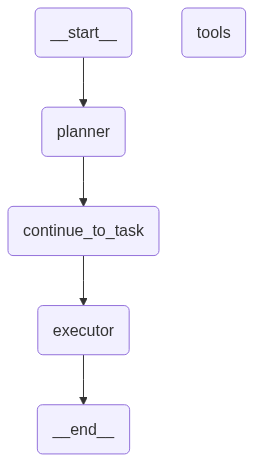

In [10]:
display(Image(rag_graph.get_graph(xray=True).draw_mermaid_png()))

In [ ]:
from langgraph.graph import MessagesState
from langgraph.graph import StateGraph, END, START
from langchain_core.messages import HumanMessage, SystemMessage
from graphs.llm_provider import get_llm_manager

class MainState(MessagesState):
    cli_input: str = ""
    files_to_read: list[str] = []
    project_structure: str = ""
    summary: str = ""

# no-op node used     
def human_input_node(state: MainState):
    pass

def router_node(state: MainState):
    """Route based on CLI input type."""
    user_input = state["cli_input"].lower().strip()

    if user_input == "init":
        return {"next": "init"}
    elif user_input in ["exit", "quit"]:
        return {"next": "exit"}
    else:
        return {"next": "question"}

def question_node(state: MainState):
    """Handle general questions using LLM."""
    llm = get_llm_manager().get_llm()
    
    question = state["cli_input"]
    print(f"\n🤖 Processing question: {question}")
    
    # Simple question answering
    response = llm.invoke(state["messages"] + [HumanMessage(content=question)])
    answer = response.content
    
    print(f"\n💡 Answer:\n{answer}")
    
    return {
        "answer": answer,
        "messages": [HumanMessage(content=question),response]
    }

def exit_node(state: MainState):
    """Handle exit command."""
    return {
        "messages": [HumanMessage(content="Goodbye! 👋")]
    }

def build_main_graph():
    """Build the main CLI routing graph."""
    builder = StateGraph(MainState)
    
    # Add nodes
    builder.add_node("human_input", human_input_node)
    builder.add_node("router", router_node)
    builder.add_node("question_handler", question_node)
    builder.add_node("init_context_handler", build_init_graph().compile())
    builder.add_node("exit_handler", exit_node)
    
    # Add edges
    builder.add_edge(START, "human_input")
    builder.add_edge("human_input", "router")
    
    # Add conditional edges from router
    builder.add_conditional_edges(
        "router",
        lambda state: state["next"],
        {
            "question": "question_handler",
            "init": "init_context_handler",
            "exit": "exit_handler"
        }
    )
    
    # All handlers end the flow
    builder.add_edge("question_handler", "human_input")
    builder.add_edge("init_context_handler", "human_input")
    builder.add_edge("exit_handler", END)
    
    return builder

In [ ]:
from pathlib import Path

from langgraph.checkpoint.memory import MemorySaver

from graphs.config_provider import get_config
from graphs.main_graph import build_graph

memory = MemorySaver()
main_graph = build_graph().compile(interrupt_before=["human_input"], checkpointer=memory)
thread = {"configurable": {"thread_id": "1"}}

initState = init_state()

# invocation should bring us to interrupt node for human input
main_graph.stream(initState, thread, stream_mode="values")

print("What would you like help with?")

while True:
    user_input = input(">>>")
    main_graph.update_state(thread, {"cli_input": user_input}, as_node="human_input")

    for event in main_graph.stream(None, thread, stream_mode="values"):
        if len(event["messages"]) > 0:
            event["messages"][-1].pretty_print()

    if event["messages"][-1].content.startswith("Goodbye"):
        break